In [1]:
import jtap_mice
jtap_mice.set_jaxcache()
from jtap_mice.inference import run_jtap, run_parallel_jtap, JTAPMiceData
from jtap_mice.viz import rerun_jtap_stimulus, rerun_jtap_single_run, jtap_plot_lr_lines, red_green_viz_notebook, plot_proposal_direction_outlier_pdf, draw_stimulus_image
from jtap_mice.utils import load_left_right_stimulus, JTAPMiceStimulus, ChexModelInput, d2r, i_, f_, slice_pt, init_step_concat, discrete_obs_to_rgb, stack_pytrees, concat_pytrees
from jtap_mice.evaluation import jtap_compute_beliefs, JTAPMice_Beliefs

import time
import rerun as rr
import genjax
from genjax import gen, ChoiceMapBuilder as C
import jax
import jax.numpy as jnp
from jax.debug import print as jprint
import numpy as np
from tqdm import tqdm
import jax.tree_util as jtu
from functools import partial
from matplotlib import pyplot as plt
from typing import List, Dict, Any, Tuple, NamedTuple

PIXEL_DENSITY = 10
SKIP_T = 4

In [2]:
LR_CONFIG= 'lr_v1'
LR_TRIAL = 1

stimulus_path = f'/home/arijitdasgupta/jtap-mice/notebooks/left_right_task/{LR_CONFIG}.json'

jtap_stimulus = load_left_right_stimulus(stimulus_path, pixel_density = PIXEL_DENSITY, skip_t = SKIP_T, trial_number = LR_TRIAL)

rgb_video_highres = load_left_right_stimulus(stimulus_path, pixel_density = PIXEL_DENSITY*5, skip_t = SKIP_T, rgb_only = True, trial_number = LR_TRIAL)

In [3]:
rerun_jtap_stimulus(discrete_obs = jtap_stimulus.discrete_obs, stimulus_name = "rg_stim1_discrete")

In [4]:
# Parameters based on default values in ChexModelInput @datastrucs.py

direction_flip_prob = 0.025

Model_Input = ChexModelInput(
    model_outlier_prob = 0.05,
    proposal_direction_outlier_tau = d2r(40.),
    proposal_direction_outlier_alpha = 3.5,
    σ_pos=10000.0,
    σ_speed=0.075,
    model_direction_flip_prob=direction_flip_prob,
    pixel_corruption_prob=0.01,
    tile_size=3,
    σ_pixel_spatial=1.0,
    image_power_beta=0.005,
    max_speed=1.0,
    max_num_occ=5,
    num_x_grid=8,
    num_y_grid=8,
    grid_size_bounds=(0.05, 0.95),
    simulate_every=1,
    σ_pos_sim=0.05,
    σ_speed_sim=0.075,
    σ_direction_sim=d2r(5.0),
    σ_pos_initprop=0.02,
    σ_direction_stepprop_flip_prob=direction_flip_prob,
    σ_speed_stepprop=0.3,
    σ_pos_stepprop=0.01
)
# PREPARE INPUT
Model_Input.prepare_hyperparameters()
Model_Input.prepare_scene_geometry(jtap_stimulus)

ESS_proportion = 0.09
smc_key_seed = np.random.randint(0, 1000000)
num_particles = 50

In [5]:
num_jtap_runs = 50

start_time = time.time()
JTAPMICE_DATA, xx = run_parallel_jtap(num_jtap_runs, smc_key_seed, Model_Input, ESS_proportion, jtap_stimulus, num_particles)
end_time = time.time()
mean_ESS = np.mean(JTAPMICE_DATA.inference.ESS.mean(axis=1))
print(f"Mean ESS: {100 * mean_ESS / num_particles:.1f}% of {num_particles} particles")
resampled = JTAPMICE_DATA.inference.resampled
resampled_pct = 100 * np.mean(resampled)
print(f"Resampling occurred in {resampled_pct:.1f}% of {jtap_stimulus.num_frames} frames")
print(f"Time taken for parallel JTAP: {end_time - start_time} seconds")

Mean ESS: 21.2% of 50 particles
Resampling occurred in 27.4% of 46 frames
Time taken for parallel JTAP: 20.31716299057007 seconds


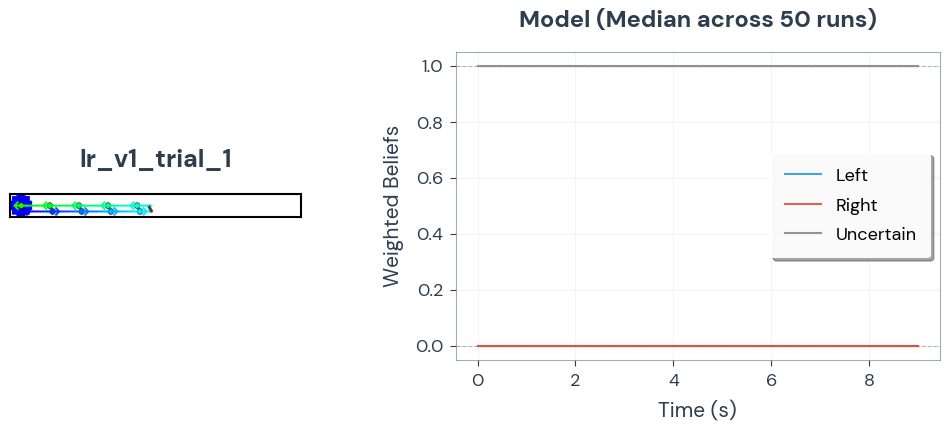

In [6]:
JTAPMice_Beliefs = jtap_compute_beliefs(JTAPMICE_DATA)
jtap_run_idx = None
show_all_lines = False
show_std_band = True
jtap_plot_lr_lines(lr_beliefs = JTAPMice_Beliefs, stimulus = jtap_stimulus, show = "model", include_baselines=False, remove_legend=False, show_std_band=show_std_band, jtap_run_idx = jtap_run_idx, include_start_frame=True, show_all_beliefs=show_all_lines, plot_stat = "median", include_stimulus=True)

In [ ]:
jtap_run_idx_viz = 9

rerun_jtap_single_run(JTAPMICE_DATA, rgb_video_highres = None, stimulus_name = "jtap_single_runv3", tracking_dot_size_range = (0.5,2), prediction_line_size_range = (0.05,0.4), jtap_run_idx = jtap_run_idx_viz, grid_dot_radius = 0.3, render_grid = True, show_velocity = True)

In [ ]:
draw_stimulus_image(jtap_stimulus, frame=0, show_blue_dotted_ring=False,gradient_trajectory=True, fade_older=False, arrow_length_px=6, arrow_thickness_px=None, gradient_extent=0.25, offset_line_proportion_ball = 0.25)

In [ ]:

    do_not_draw_seconds=True,    # NEW: Default is True (do not annotate seconds)
    direction_arrow_color=(0, 0, 200),   # NEW: color of direction arrows (BGR)
    direction_arrow_size=10,              # NEW: length of direction arrow (pixels, before upscale)
    direction_arrow_thickness=1,          # NEW: thickness of arrow
    arrow_interval=15,                    # Frame interval between direction arrows
    gradient_trajectory=True,             # Whether to use a color gradient for the trajectory
    fade_older=True,                      # Whether to fade older parts of trajectory
):